In [1]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
from tqdm.auto import trange
import itertools as it
import h5py
from copy import deepcopy

import numpy as np
import cvxpy as cp
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# from sca import *
from utils import *

In [2]:
num_ue = 4
mu = 4
Pc=1
Pmax = 100

h0 = np.array([[3.6727226e+01, 7.6416140e+00, 2.1367569e+00, 6.4129746e-01],
               [4.0369835e-01, 5.1982952e+01, 2.0964766e+00, 1.0794865e+00],
               [9.9917613e-03, 3.0490181e+00, 1.5596890e+02, 3.0584135e+00],
               [1.2896190e+00, 1.1164372e+00, 8.0090504e+00, 1.6805302e+02]])

p0 = np.array( [0.16516957, 0.08670427, 0.07471375, 0.09479848])

# p0 = np.full(num_ue, Pmax).astype(float)
#


print(p0)
p2 = inner_optim_sgd(p0, h0, Pmax, Pc,  mu, eps=1e-8, max_iters=100)
print(p0)
p3 = inner_optim_cvx(p0, h0, Pmax, Pc,  mu, eps=1e-8, max_iters=100)

p2,p3

[0.16516957 0.08670427 0.07471375 0.09479848]
[0.16516957 0.08670427 0.07471375 0.09479848]


/opt/conda/lib/python3.7/site-packages/diffcp/cone_program.py:259: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")
/opt/conda/lib/python3.7/site-packages/cvxpy/problems/problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


(array([0.87605417, 0.3848201 , 0.26317635, 0.4279161 ], dtype=float32),
 array([0.        , 0.19807445, 0.        , 0.70060902]))

In [242]:
np.full(num_ue, Pmax)

array([100, 100, 100, 100])

In [94]:
xx.flatten()*Pmax

torch.cat((xx, h0.flatten()*Pmax, [Pmax]))

TypeError: expected Tensor as element 1 in argument 0, but got numpy.ndarray

## unfolding pytorch blocks

In [219]:
def form_input_mlp_numpy(pt, h, Pmax, Pc, mu):
    x = torch.Tensor(
        np.log10(
            np.concatenate((pt, h.flatten()*Pmax, [Pmax]))
        ).reshape((1,-1)).astype(float)
    )
    return x


def form_input_mlp_torch(pt, h, Pmax, Pc, mu):
    x = torch.log10(
            torch.cat((pt.view(-1), 
                       h.view(-1)*Pmax, 
                       torch.empty(1).fill_(Pmax)
                      ))
        ).view((1,-1)).float()
    return x


# layer = ([128, 64, 32, 16, 8], ['elu', 'relu', 'elu', 'relu', 'elu'])
class basic_mlp(nn.Module):
    def __init__(self, in_size, out_size, h_sizes, activs=None, dropout=0.3, constraint=[0,1]):
        super(basic_mlp, self).__init__()
        
        # activation functions
        activations = {'elu': nn.ELU(),'relu': nn.ReLU()}
        activs = ['relu']*len(h_sizes) if activs is None else activs
        
        # modulelist container for hidden layers
        self.hidden = nn.ModuleList()
        self.hidden.append(nn.Linear(in_size, h_sizes[0]))
        self.hidden.append(activations[activs[0]])
        for k in range(len(h_sizes)-1):
            self.hidden.append(nn.Linear(h_sizes[k], h_sizes[k+1]))
            self.hidden.append(activations[activs[k+1]])
            self.hidden.append(nn.Dropout(dropout))
            
        self.hidden.append(nn.Linear(h_sizes[k+1], out_size))
        self.activ_fin = nn.Sigmoid()
        self.constraints = torch.Tensor(constraint)
        
    def forward(self, x):
        for i, hidden in enumerate(self.hidden):
            x = hidden(x)
        return x
#         x = self.activ_fin(x)
        x = nn.functional.normalize(x)
        scale = self.constraints[1] - self.constraints[0]
        return x*scale + self.constraints[0]
    

class unfold_block_mlp(nn.Module):
    def __init__(self, in_size, out_size, h_sizes, 
                 activs=None, dropout=0.3, constraint=[0,1], inner_optim='fixed-sgd'):
        super(unfold_block_mlp, self).__init__()
        
        self.gamma = basic_mlp(in_size, out_size, h_sizes, activs, dropout, [0,1])
        self.size  = out_size
        
        m1, m2 = inner_optim.split('-')
        if m1=='fixed':
            if m2=='sgd':
#                 self.optim = inner_optim_sgd
#                 self.kwargs = {'learning_rate':.1, 'max_iters':10}
                self.forward = self.forward_fixed
            elif m2=='cvx':
                pass
            else:
                raise
        elif m1 == 'learned':
            if m2=='mlp':
                self.optim = basic_mlp(in_size, out_size, h_sizes, activs, dropout, constraint)
#                 self.kwargs = {}
                self.forward = self.forward_learned
            elif m2=='gnn':
                pass
            else:
                raise            
        else:
            raise
            
    def forward_learned(self, pt, h, Pmax, Pc, mu):
        x = form_input_mlp_torch(pt, h, Pmax, Pc, mu) 
        # optim p2/3
        x_sol = self.optim(x)
        # compute gamma
        gamma = self.gamma(x)
        # update pt
        x_new = x[:,:self.size] + gamma * (x_sol - x[:,:self.size])
        
        return x_new, gamma
    
    
    def forward_fixed(self, pt, h, Pmax, Pc, mu):
        x = form_input_mlp_numpy(pt, h, Pmax, Pc, mu)
        # optim p2/3
        x_sol = inner_optim_sgd(pt, h, Pmax, Pc, mu, eps=1e-8, max_iters=10, learning_rate=.1)
        # compute gamma
        gamma = self.gamma(x)
        # update pt
#         x_new = x[:,:self.size] - gamma * (x[:,:self.size] - x_sol)
#         print(type(x), type(gamma), type(x_sol), type( x[:,:self.size]))
        x_sol = torch.FloatTensor(x_sol)
        x_new = x[:,:self.size] + gamma * (x_sol - x[:,:self.size])
        
        return x_new, gamma
        
        
        
class USCA_MLP(nn.Module):
    def __init__(self, num_layers, in_size, out_size, h_sizes, 
                 activs=None, dropout=0.3, constraint=[0,1], inner_optim='learned-mlp'):
        super(USCA_MLP, self).__init__()
        # build a block
        self.sca = nn.ModuleList()
        for l in range(num_layers):
            self.sca.append(unfold_block_mlp(in_size, out_size, h_sizes, 
                                             activs, dropout, constraint, inner_optim))
        
    def forward(self, pt, h, Pmax, Pc, mu):  
        
        for i, sca_block in enumerate(self.sca):
            print(pt)
            pt, gamma = sca_block(pt, h, Pmax, Pc, mu)
            pt = pt.data.numpy()[0]
            print(gamma)

        return pt, gamma
    
    

class USCA_MLP_R(nn.Module):
    def __init__(self, num_layers, in_size, out_size, h_sizes, 
                 activs=None, dropout=0.3, constraint=[0,1], inner_optim='learned-mlp'):
        super(USCA_MLP_R, self).__init__()
        # build a block
        self.sca = nn.ModuleList()
        sca_block = unfold_block_mlp(in_size, out_size, h_sizes, 
                                             activs, dropout, constraint, inner_optim)
        for l in range(num_layers):
            self.sca.append(sca_block)
        
    def forward(self, pt, h, Pmax, Pc, mu):  
        
        for i, sca_block in enumerate(self.sca):
            print(pt)
            pt, gamma = sca_block(pt, h, Pmax, Pc, mu)
            pt = pt.data.numpy()[0]
            print(gamma)

        return pt, gamma

In [173]:
y_pred

tensor([[nan, nan, nan, nan]], grad_fn=<ClampBackward>)

## unfold optim p2/3 block

torch.Size([1, 21])


(3.7790903665226443, 3.610863813052445, 2.2788778937239726)

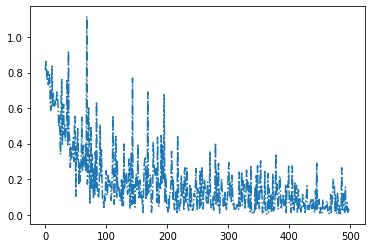

In [221]:
in_size = len(p0)**2 + len(p0) + 1
out_size = len(p0)

h_sizes = [128, 64, 32, 32, 32, 16, 8]
activs = ['elu', 'relu', 'elu', 'relu', 'elu', 'relu',  'elu']

xx = torch.Tensor(
    np.log10(
        np.concatenate((p0, h0.flatten()*Pmax, [Pmax]))
    ).reshape((1,-1)).astype(float)
)
print(xx.shape)

model = basic_mlp(in_size, out_size, h_sizes, activs, dropout=0.2, constraint=[0,Pmax])

y_true =  torch.Tensor(p2)
opt = torch.optim.Adam(model.parameters(), lr=0.0005)

ll = []
model.train()
for ep in trange(500):
    y_pred = model(xx)
    loss = torch.mean(((y_pred-y_true)/y_true)**2)
    
#     print(loss)
    ll.append(loss.item())

    opt.zero_grad()
    loss.backward() #vector loss
    opt.step()

    
model.eval()
y_pred = model(xx) 

plt.plot(ll, '-.')    

f(y_pred.detach().numpy(), h0, mu, Pc), f(p2, h0, mu, Pc), f(p3, h0, mu, Pc)

In [143]:
y_pred, y_true

(tensor([[0.7664, 0.3311, 0.6195, 0.3429]], grad_fn=<AddmmBackward>),
 tensor([0.8850, 0.3974, 0.6273, 0.4269]))

## unfold a sca block (learned inner opt)

(5.0917982764658, 5.234697992895697)

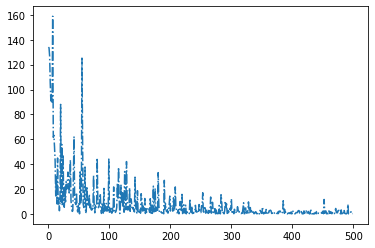

In [223]:
from utils import *
model2 = unfold_block_mlp(in_size, out_size, h_sizes, activs, dropout=0.2, constraint=[0,Pmax], inner_optim='learned-mlp')

_,p4 = SCA(h0, mu, Pc, Pmax = Pmax, pt = p0, SolverMaxIter=100, MaxIter = 1, 
    parm_alpha = 1e-8, parm_beta = 0.01, RelTolFun = 1e-12, RelTolVal = 1e-12, InnerOpt='sgd')
y_true =  torch.Tensor(p4[-1])
opt = torch.optim.Adam(model2.parameters(), lr=0.007)


pt = torch.FloatTensor(p0)
h = torch.FloatTensor(h0)


ll = []
model2.train()
for ep in trange(500):
    y_pred, gamma = model2(pt, h, Pmax, Pc,  mu)
#     y_pred.clamp_(0,Pmax)
    loss = torch.mean(((y_pred-y_true)/y_true)**2)
    
#     print(loss)
    ll.append(loss.item())

    opt.zero_grad()
    loss.backward() #vector loss
    opt.step()
    
model2.eval()
y_pred, gamma = model2(pt, h, Pmax, Pc,  mu)
y_pred.clamp_(0,Pmax)

plt.plot(ll, '-.')    

f(y_pred.detach().numpy(), h0, mu, Pc), f(p4[-1], h0, mu, Pc)

## unfold a sca block (fixed inner opt)

(5.21899653664296, 5.234697992895697)

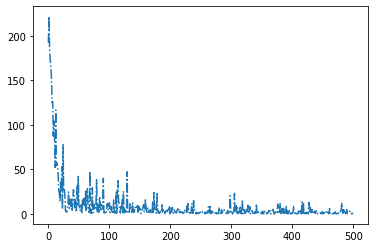

In [224]:
from utils import *
model2 = unfold_block_mlp(in_size, out_size, h_sizes, activs, dropout=0.2, constraint=[0,Pmax], inner_optim='fixed-sgd')

_,p4 = SCA(h0, mu, Pc, Pmax = Pmax, pt = p0, SolverMaxIter=10, MaxIter = 1, 
    parm_alpha = 1e-8, parm_beta = 0.01, RelTolFun = 1e-12, RelTolVal = 1e-12, InnerOpt='sgd')
y_true =  torch.Tensor(p4[-1])
opt = torch.optim.Adam(model2.parameters(), lr=0.007)

ll = []
model2.train()
for ep in trange(500):
    y_pred, gamma = model2(p0, h0, Pmax, Pc,  mu)
#     y_pred.clamp_(0,Pmax)
    loss = torch.mean(((y_pred-y_true)/y_true)**2)
    
#     print(loss)
    ll.append(loss.item())

    opt.zero_grad()
    loss.backward() #vector loss
    opt.step()
    
model2.eval()
y_pred, gamma = model2(p0, h0, Pmax, Pc,  mu)
y_pred.clamp_(0,Pmax)

plt.plot(ll, '-.')    

f(y_pred.detach().numpy(), h0, mu, Pc), f(p4[-1], h0, mu, Pc)

In [32]:
gamma

tensor([[0.5651, 0.7888, 0.5512, 0.7733]], grad_fn=<AddmmBackward>)

## unfolded sca pipeline

In [226]:

from utils import *
model3 = USCA_MLP_R(5, in_size, out_size, h_sizes, activs, 
                  dropout=0.2, constraint=[0,Pmax], inner_optim='fixed-sgd')

_,p4 = SCA(h0, mu, Pc, Pmax = Pmax, pt = p0, SolverMaxIter=100, MaxIter = 1, 
    parm_alpha = 1e-8, parm_beta = 0.01, RelTolFun = 1e-12, RelTolVal = 1e-12, InnerOpt='sgd')
y_true =  torch.Tensor(p4[-1])
opt = torch.optim.Adam(model3.parameters(), lr=0.007)

ll = []
model2.train()

pt = torch.FloatTensor(p0)
h = torch.FloatTensor(h0)

for ep in trange(500):
    y_pred, gamma = model3(p0, h0, Pmax, Pc,  mu)
#     y_pred.clamp_(0,Pmax)
    loss = torch.mean(((y_pred-y_true)/y_true)**2)
    
#     print(loss)
    ll.append(loss.item())

    opt.zero_grad()
    loss.backward() #vector loss
    opt.step()
    
    break
    
model2.eval()
y_pred, gamma = model3(p0, h0, Pmax, Pc,  mu)
y_pred.clamp_(0,Pmax)

plt.plot(ll, '-.')    

f(y_pred.detach().numpy(), h0, mu, Pc), f(p4[-1], h0, mu, Pc)

[0.16524066 0.08673408 0.0747326  0.09483179]
tensor([[-0.0528,  0.2987,  0.0827,  0.2320]], grad_fn=<AddmmBackward>)
[-0.86997205 -0.62600064 -0.97979903 -0.68668365]
tensor([[nan, nan, nan, nan]], grad_fn=<AddmmBackward>)
[nan nan nan nan]
tensor([[nan, nan, nan, nan]], grad_fn=<AddmmBackward>)
[nan nan nan nan]
tensor([[nan, nan, nan, nan]], grad_fn=<AddmmBackward>)
[nan nan nan nan]
tensor([[nan, nan, nan, nan]], grad_fn=<AddmmBackward>)



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


TypeError: rsub() received an invalid combination of arguments - got (Tensor, numpy.ndarray), but expected one of:
 * (Tensor input, Tensor other, *, Number alpha)
 * (Tensor input, Number other, Number alpha)


In [2]:
it_count1  = []

def SCA(h, mu, Pc, Pmax, pt = None, MaxIter = 10000, SolverMaxIter = 1000,
         parm_alpha = 1e-8, parm_beta = 0.01, 
         RelTolFun = 1e-12, RelTolVal = 1e-12, InnerOpt='sgd'):
    """
    InnerOpt: sgd, cvx, ...
    Init    : last, full, ...
    """

    if pt is None:
        pt = np.full(h.shape[-1], Pmax)

    def f(p): # verified
        s = h * p # (4,4) * (4,) --> (4,4)
        
        direct = np.diag(s)
        ifn = 1 + np.sum(s, axis=-1) - direct
        rates = np.log(1+direct/ifn)
        ee = rates / (mu * p + Pc)

        return np.sum(ee)

    def gradr(p): # verified
        s = h * p
        tmp = 1 + np.sum(s, axis=-1) # 1 + sum beta + a
        tmp2 = tmp - np.diag(s)
        fac = np.diag(s) / (tmp * tmp2)
        
        grad = h.copy()      
        grad = -(fac * grad.T).T
    
        grad[np.diag_indices_from(grad)] = 1/tmp * np.diag(h)#tmp2/(tmp*tmp2) * np.diag(h)

        return grad

    def gradf(p): # verified
        tmp = 1 / (mu * p + Pc)
        gr = gradr(p)
        
        t1 = np.sum((gr.T * tmp).T, axis=0)

        s = h * p
        direct = np.diag(s)
        ifn = 1 + np.sum(s, axis=-1) - direct
        rates = np.log(1+direct/ifn)
        
        t2 = mu * rates * tmp**2

        return t1 - t2

    # gradient step parameter
    if InnerOpt.lower() == "sgd":
        inner_opt = inner_optim_sgd
        kargws = {"learning_rate":.1}
        
    elif InnerOpt.lower() == "cvx":
        inner_opt = inner_optim_cvx
        kargws = {"verbose": False}
        
    else:
        raise NotImplemented
        
        
    OBJ, PT = [f(pt)],[pt]
    cnt = 0
    while True:
                
        cnt += 1
        pvar = inner_opt(pt, h, Pmax, Pc, mu, eps=1e-8, max_iters=SolverMaxIter, **kargws)
                
        # calculate gradient step
        Bpt = pvar - pt
        gamma = 1

        old_obj = f(pt)
        old_pt = pt
        while f(pt + gamma * Bpt) < old_obj + parm_alpha * gamma * gradf(pt) @ Bpt:
            gamma *= parm_beta

#         pt = np.clip(gamma * Bpt + pt, 0, Pmax)
        pt += gamma * Bpt
        obj = f(pt)
        
        OBJ.append(obj)
        PT.append(pt)

        with np.errstate(divide='ignore'):
            if abs(obj/old_obj - 1) < RelTolFun and np.linalg.norm(pt-old_pt, np.inf) / np.linalg.norm(pt, np.inf) < RelTolVal:
                break
        
        if cnt > MaxIter:
            print('MaxIter')
            break

    it_count1.append(cnt)
    return (OBJ, PT)

In [255]:
it_count1

[1, 1, 1, 1]

In [3]:

num_ue = 7
mu = 4
Pc = 1

INITS = ['last','full']#,'rand']
OPTIM = ['sgd', 'cvx']

INNER_MAXIT = [6]#, 2, 5, 10, 15, 20, 35, 50, 100, 150, 200]
# outer_maxit = [1, 2, 5, 10, 20, 50, 150]

log_outiters = dict(zip(INITS,[[] for _ in INITS]))
log_all = dict(zip(OPTIM,[[] for _ in OPTIM]))

for opt in OPTIM:
    
    for im in INNER_MAXIT:

        log_monitor = {
            'objective':dict(zip(INITS,[[] for _ in INITS])),
            'pwr_alloc':dict(zip(INITS,[[] for _ in INITS]))
        }


        dfn1 = '../../data/wsee%d-processed.h5'%num_ue
        with h5py.File(dfn1, "r") as f:
            PdB = f['input']['PdB'][...] # this is fixed

        assert np.allclose(PdB, np.array(range(-30,20+1,1)))
        Plin = 10**(np.asarray(PdB/10))

        dfn2 = '../../data_my/channels-%d.h5'%num_ue
    #     dfn2 = '../../data_my/channels-HataSuburban-%d.h5'%num_ue
        with h5py.File(dfn2, "r") as f:
            # Get the data
            data = {k:{kk: v[:] for kk,v in f[k].items()} for k in f.keys()}

            Hs = data['input']['channel_to_noise_matched']

            for hidx in tqdm([456]):#trange(Hs.shape[0]):#tqdm(np.random.permutation(Hs.shape[0])):

                h = Hs[hidx]
                pt = None

                p_perm = list(range(len(Plin)))#
                for pidx in tqdm(p_perm, desc=str(im)):

                    p = Plin[pidx]

                    O = dict(zip(INITS,[[] for _ in INITS]))
                    P = dict(zip(INITS,[[] for _ in INITS]))
                    
                    for istr in INITS: #['last','full']
                        if istr == 'last' and pt is not None:
                            p0 = pt
                        elif istr == 'full' or pt is None:
                            p0 = np.full(num_ue, p)
                        else:
                            raise NotImplemented
                            
                        try:
                            assert istr == 'last' # dont do full 
                            O[istr], P[istr] = SCA(h, mu, Pc, Pmax = p, pt = p0, 
                                                    SolverMaxIter=im, MaxIter = 1000, 
                                                    parm_alpha = 1e-8, parm_beta = 0.01, 
                                                    RelTolFun = 1e-12, RelTolVal = 1e-12, 
                                                    InnerOpt=opt)
                        except:
                            O[istr], P[istr] = [-np.inf], [np.full(num_ue, p)]
                            
                    # best init
                    bstr = max(O, key=lambda key: O[key][-1]) 
                    pt = P[bstr][-1]

                    print('%s init is best!'%bstr.upper(), 
                          '; objective ee =', O[bstr][-1], 
                          '; #outer iters =', len(O[bstr]),
                          '; pt =', pt, '; Pmax =', p)

                    [log_monitor['objective'][k].append(v) for k,v in O.items()]
                    [log_monitor['pwr_alloc'][k].append(v) for k,v in P.items()]

                break

            lens = {}
            for k,v in log_monitor['objective'].items():
                lens[k] = np.array([len(vv) for vv in v])

            eeval = {}
            for k,v in log_monitor['objective'].items():
                eeval[k] = np.array([vv[-1] for vv in v])

            for k,v in log_monitor['objective'].items():
                length = [len(vv) for vv in v]
                ee = eeval[k][eeval[k]>=0]

                print(k)
                print('#iters: %.2f'%np.mean(length), "(+- %.2f"%np.std(length), ")")
                print('#eeval: %.2f'%np.mean(ee), "(+- %.2f"%np.std(ee), ")")
                print()
                log_outiters[k].append(length)
                
    log_all[opt] = deepcopy(log_monitor)


LAST init is best! ; objective ee = 0.7451757968096964 ; #outer iters = 3 ; pt = [0.001 0.001 0.001 0.001 0.001 0.001 0.001] ; Pmax = 0.001
LAST init is best! ; objective ee = 0.8890519807457259 ; #outer iters = 3 ; pt = [0.00125893 0.00125893 0.00125893 0.00125893 0.00125893 0.00125893
 0.00125893] ; Pmax = 0.0012589254117941675
LAST init is best! ; objective ee = 1.0510047746812365 ; #outer iters = 3 ; pt = [0.00158489 0.00158489 0.00158489 0.00158489 0.00158489 0.00158489
 0.00158489] ; Pmax = 0.001584893192461114
LAST init is best! ; objective ee = 1.2301363669702388 ; #outer iters = 3 ; pt = [0.00199526 0.00199526 0.00199526 0.00199526 0.00199526 0.00199526
 0.00199526] ; Pmax = 0.001995262314968879
LAST init is best! ; objective ee = 1.424615647193812 ; #outer iters = 3 ; pt = [0.00251189 0.00251189 0.00251189 0.00251189 0.00251189 0.00251189
 0.00251189] ; Pmax = 0.0025118864315095794
LAST init is best! ; objective ee = 1.6316999295178298 ; #outer iters = 3 ; pt = [0.00316228 0.

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LAST init is best! ; objective ee = 0.7451757690115423 ; #outer iters = 2 ; pt = [0.001 0.001 0.001 0.001 0.001 0.001 0.001] ; Pmax = 0.001
LAST init is best! ; objective ee = 0.7451757690115423 ; #outer iters = 2 ; pt = [0.001 0.001 0.001 0.001 0.001 0.001 0.001] ; Pmax = 0.0012589254117941675


/opt/conda/lib/python3.7/site-packages/diffcp/cone_program.py:259: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")
/opt/conda/lib/python3.7/site-packages/cvxpy/problems/problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


LAST init is best! ; objective ee = 0.9377973465006514 ; #outer iters = 3 ; pt = [0.0009587  0.00155665 0.00054207 0.00161867 0.         0.00086692
 0.        ] ; Pmax = 0.001584893192461114
LAST init is best! ; objective ee = 1.1928525733665167 ; #outer iters = 3 ; pt = [0.00142502 0.00213921 0.00111131 0.00220388 0.         0.00136837
 0.        ] ; Pmax = 0.001995262314968879
LAST init is best! ; objective ee = 1.4454760616863065 ; #outer iters = 3 ; pt = [1.98738350e-03 2.83808732e-03 1.75514486e-03 2.91562182e-03
 0.00000000e+00 1.94374749e-03 1.35068004e-05] ; Pmax = 0.0025118864315095794
LAST init is best! ; objective ee = 1.6999872517535364 ; #outer iters = 3 ; pt = [2.64921045e-03 3.70236024e-03 2.51594329e-03 3.79949109e-03
 2.52097444e-05 2.62077348e-03 1.02407687e-04] ; Pmax = 0.0031622776601683794
LAST init is best! ; objective ee = 1.9463526486668217 ; #outer iters = 6 ; pt = [0.0030682  0.00475158 0.00342914 0.00477903 0.00014115 0.00329991
 0.00018096] ; Pmax = 0.003981

In [4]:
p

100.0

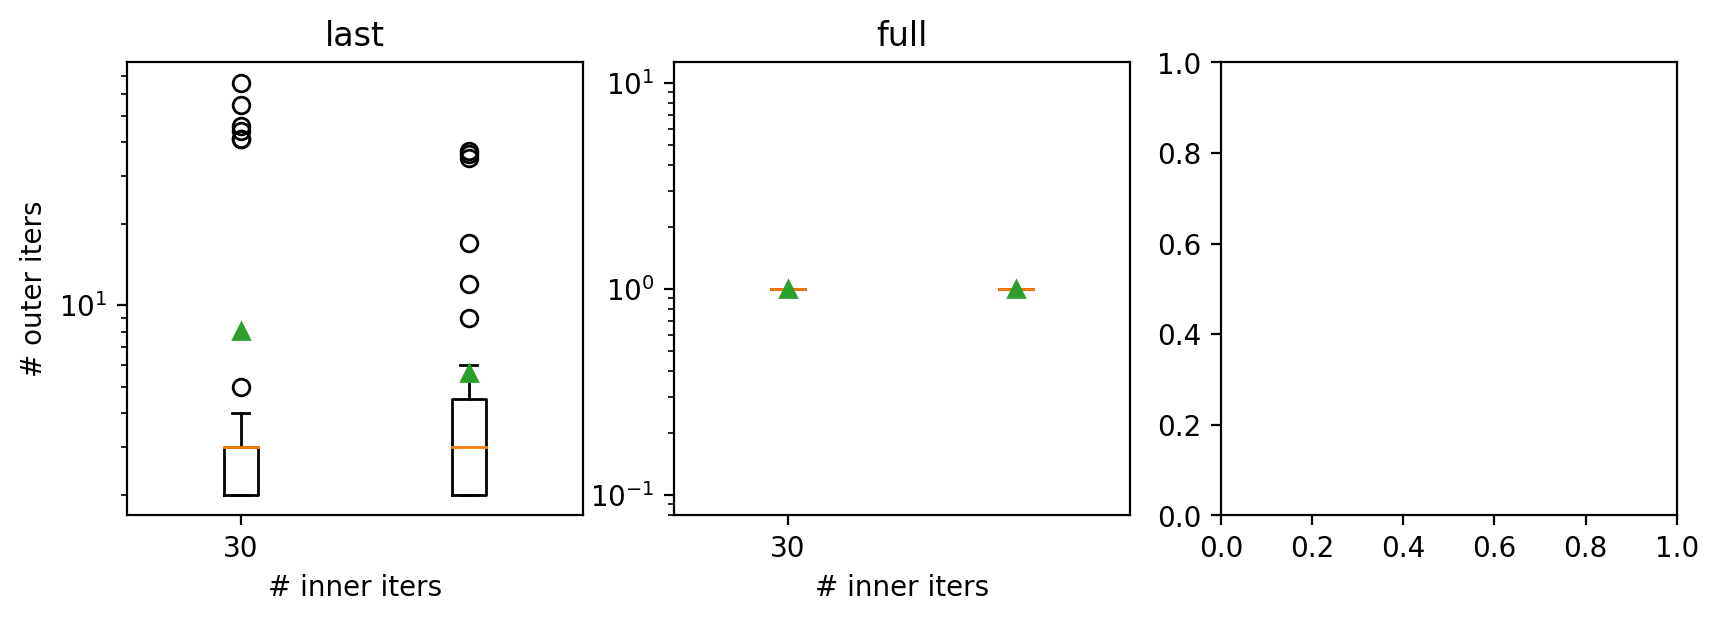

In [87]:
fig, ax = plt.subplots(1,3, figsize=(10,3), dpi=200)
for i, (k,v) in enumerate(log_outiters.items()): 
    ax[i].boxplot(np.array(v).T, showmeans=True)

    ax[i].set_title(k)
    ax[i].set_xticks(range(1,len(INNER_MAXIT)+1))
    ax[i].set_xticklabels(INNER_MAXIT)
    ax[i].set_yscale('log')
    ax[i].set_xlabel('# inner iters')
    
ax[0].set_ylabel('# outer iters')
# plt.legend()
plt.show()

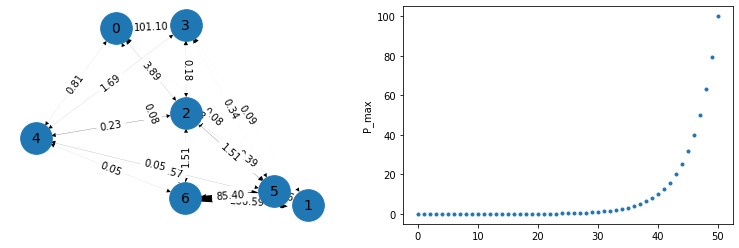

In [147]:

# visualize channels and plin

H = np.array(h)
np.fill_diagonal(H, 0)

G = nx.from_numpy_matrix(H, create_using=nx.DiGraph)
pos = nx.spring_layout(G)
edge_labels = dict([((u,v,), f"{d['weight']:.2f}") for u,v,d in G.edges(data=True)])

edges = G.edges()
weights = [G[u][v]['weight']/50 for u,v in edges]

plt.figure(figsize=(13,4))
plt.subplot(121)
nx.draw(G, pos, node_size=1000,font_size=14,
        width=weights, with_labels=True) 
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.subplot(122)
plt.plot(Plin,'.')
plt.ylabel('P_max')
plt.show()




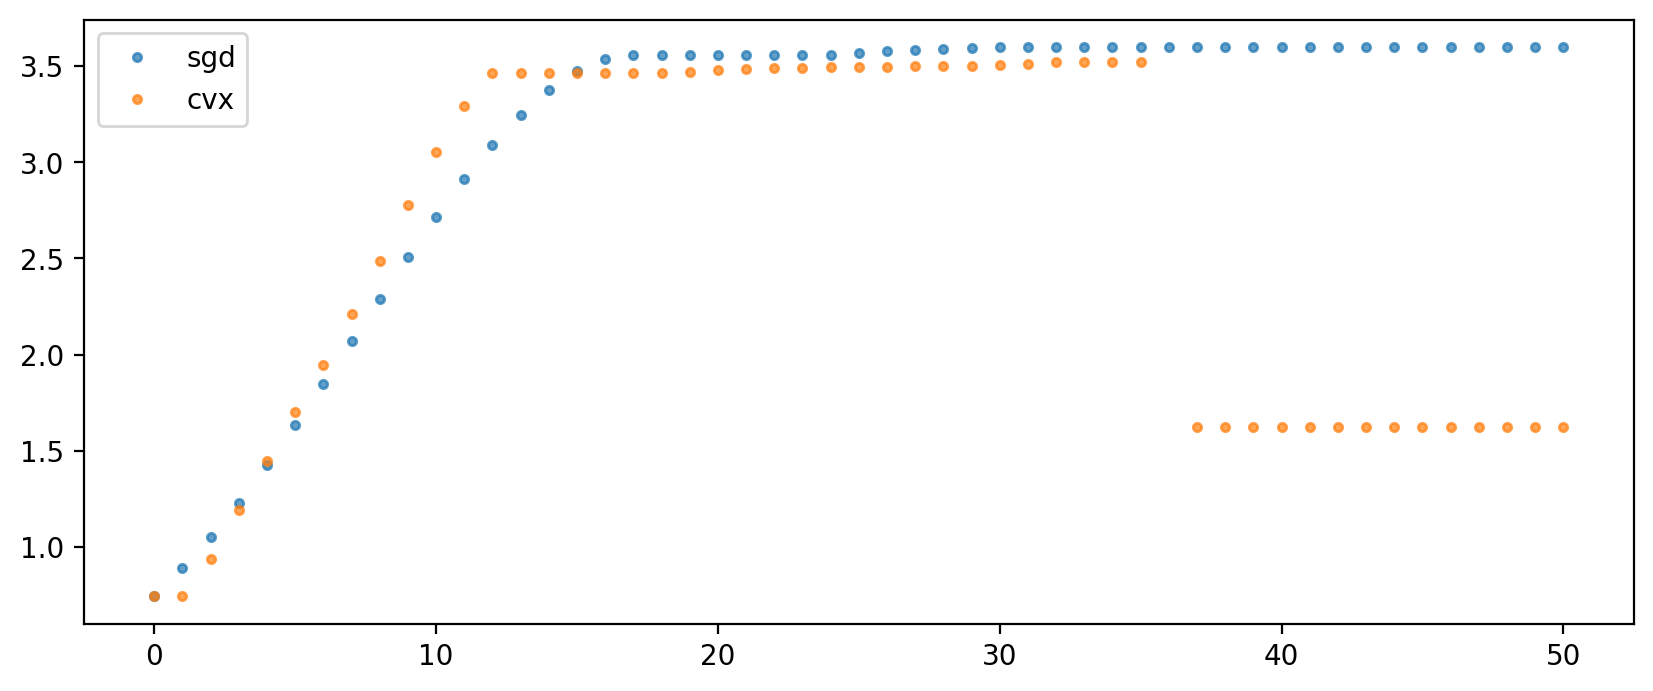

In [148]:
plt.figure(figsize=(10,4), dpi=200)

plt.plot([v[-1] for v in log_all['sgd']['objective']['last']], '.', alpha=.7, label='sgd')
plt.plot([v[-1] for v in log_all['cvx']['objective']['last']], '.', alpha=.7, label='cvx')

plt.legend()
plt.show()

In [150]:
lens = {}
for k,v in log_monitor['objective'].items():
    lens[k] = np.array([len(vv) for vv in v])

eeval = {}
for k,v in log_monitor['objective'].items():
    eeval[k] = np.array([vv[-1] for vv in v])
    
for k,v in log_monitor['objective'].items():
    length = [len(vv) for vv in v]
    ee = eeval[k][eeval[k]>=0]
    
    print(k)
    print('#iters: %.2f'%np.mean(length), "(+- %.2f"%np.std(length), ")")
    print('#eeval: %.2f'%np.mean(ee), "(+- %.2f"%np.std(ee), ")")
    print()
    
    
# # plot ee
# for k,v in log_monitor['objective'].items():
#     plt.plot(p_perm, eeval[k],'.', label=k, alpha=.7)
# #     plt.plot(eeval[k],'.', label=k, alpha=.7)
# plt.xticks(range(len(Plin))[::5], [np.round(pl,1) for pl in Plin[::5]])
# plt.legend()
# plt.show()

last
#iters: 7.02 (+- 12.73 )
#eeval: 2.58 (+- 0.97 )

full
#iters: 1.00 (+- 0.00 )
#eeval: nan (+- nan )



/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# MLP

In [227]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse
import torch.nn.functional as F

from tqdm.auto import trange

# layer = ([128, 64, 32, 16, 8], ['elu', 'relu', 'elu', 'relu', 'elu'])
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        # permutation
        self.fc1 = nn.Linear(input_size**2+1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8)
        self.fc6 = nn.Linear(8, input_size)
        self.elu = nn.ELU()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.elu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.elu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = self.relu(self.fc4(x))
        x = self.elu(self.fc5(x))
        x = self.fc6(x)
        
        return x
    
    
class GCN(torch.nn.Module):
    def __init__(self, dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dim, 32)
        self.conv2 = GCNConv(32, 128)
        self.conv3 = GCNConv(128, 64)
        self.conv4 = GCNConv(64, 16)
        self.conv5 = GCNConv(16, 8)
        self.conv6 = GCNConv(8, dim)
#         self.final = nn.Linear(dim, dim) 

    def forward(self, x, edge_index, edge_weights):
#         x, edge_index = data.x, data.edge_index

        x = F.elu(self.conv1(x, edge_index, edge_weight=edge_weights))
#         x = F.dropout(x, training=self.training)
        
        x = F.relu(self.conv2(x, edge_index, edge_weight=edge_weights))
#         x = F.dropout(x, training=self.training)
        
        x = F.elu(self.conv3(x, edge_index, edge_weight=edge_weights))
#         x = F.dropout(x, training=self.training)
        
        x = F.relu(self.conv4(x, edge_index, edge_weight=edge_weights))
#         x = F.dropout(x, training=self.training)
        
        x = F.elu(self.conv5(x, edge_index, edge_weight=edge_weights))
#         x = F.dropout(x, training=self.training)

        x = self.conv6(x, edge_index, edge_weight=edge_weights)

#         return F.log_softmax(x, dim=1)
        return x#self.final(x)



from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(MLP(num_ue))
count_parameters(GCN(1))

+------------+------------+
|  Modules   | Parameters |
+------------+------------+
| fc1.weight |    2176    |
|  fc1.bias  |    128     |
| fc2.weight |    8192    |
|  fc2.bias  |     64     |
| fc3.weight |    2048    |
|  fc3.bias  |     32     |
| fc4.weight |    512     |
|  fc4.bias  |     16     |
| fc5.weight |    128     |
|  fc5.bias  |     8      |
| fc6.weight |     32     |
|  fc6.bias  |     4      |
+------------+------------+
Total Trainable Params: 13340
+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |     32     |
|  conv1.bias  |     32     |
| conv2.weight |    4096    |
|  conv2.bias  |    128     |
| conv3.weight |    8192    |
|  conv3.bias  |     64     |
| conv4.weight |    1024    |
|  conv4.bias  |     16     |
| conv5.weight |    128     |
|  conv5.bias  |     8      |
| conv6.weight |     8      |
|  conv6.bias  |     1      |
+--------------+------------+
Total Trainable Params: 13729


13729

In [228]:
#--- data---

num_ue = 4
mu = 4
Pc = 1

device = torch.device('cpu')
model = MLP(num_ue).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)

# # train data
# dfn3 = '../../data/dset%d.h5'%num_ue
# with h5py.File(dfn3, "r") as handle:
#     X_tr = handle['training']['input'][...]
#     y_tr = handle['training']['xopt'][...]
    
# # validation data
# dfn4 = '../../data/dset%d.h5'%num_ue
# with h5py.File(dfn4, "r") as handle:
#     X_va = handle['validation']['input'][...]
#     y_va = handle['validation']['xopt'][...]
      
        
#--- data---


# train data
dfn3 = '../../data/results_hataUrban_noSF.h5'
with h5py.File(dfn3, "r") as handle:
    Hs = handle['input']["channel_to_noise_matched"]
    Plin = 10**(np.asarray(handle['input']['PdB'][...], dtype=np.float)/10)
    xopt = handle['xopt']
    
    X_tr = np.empty((Hs.shape[0]*len(Plin),Hs.shape[1]*Hs.shape[2]+1))
    y_tr = np.empty((Hs.shape[0]*len(Plin),num_ue))
    
    i=0
    for hidx in trange(Hs.shape[0]):
#         h = Hs[hidx]
        for pidx in range(len(Plin)):
            p_max = Plin[pidx]
#             h = h.flatten().astype(float) # flatten h
            edge_index_tr, h = dense_to_sparse(torch.from_numpy(Hs[hidx].astype(float)))
            X_tr[i] = np.log10(np.concatenate((h*p_max, [p_max])).reshape((1,-1)))
            y_tr[i] = xopt[hidx,pidx,...]
            i+=1

y_tr = y_tr[~np.any(np.isnan(X_tr),-1)]     
X_tr = X_tr[~np.any(np.isnan(X_tr),-1)]                

# validation data
dfn4 = '../../data/results_hataUrban.h5'
with h5py.File(dfn4, "r") as handle:
    Hs = handle['input']["channel_to_noise_matched"]
    Plin = 10**(np.asarray(handle['input']['PdB'][...], dtype=np.float)/10)
    xopt = handle['xopt']
    
    X_va = np.empty((Hs.shape[0]*len(Plin),Hs.shape[1]*Hs.shape[2]+1))
    y_va = np.empty((Hs.shape[0]*len(Plin),num_ue))
    
    i=0
    for hidx in trange(Hs.shape[0]):
#         h = Hs[hidx]
        for pidx in range(len(Plin)):
            p_max = Plin[pidx]
            edge_index_va, h = dense_to_sparse(torch.from_numpy(Hs[hidx].astype(float)))
            X_va[i] = np.log10(np.concatenate((h*p_max, [p_max])).reshape((1,-1))).astype(float)
            y_va[i] = xopt[hidx,pidx,...]
            i+=1

# dfn4 = '../../data/dset%d.h5'%num_ue
# with h5py.File(dfn4, "r") as handle:
#     X_va = handle['validation']['input'][...]
#     y_va = handle['validation']['xopt'][...]

        
#--- (end)---

        
print(X_tr.shape, y_tr.shape)
print(X_va.shape, y_va.shape)



(51000, 17) (51000, 4)
(51000, 17) (51000, 4)


# GCN LEARNING

In [25]:
device = torch.device('cuda')
# model = MLP(num_ue).to(device)
# opt = torch.optim.Adam(model.parameters(), lr=0.01)
    
k_fold = 2
bs = 256

import numpy as np
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)
tr_loss1, va_loss1, te_loss1 = {},{},{}

for k, (train_index, valid_index) in enumerate(skf.split(X_tr, np.asarray([True]*y_tr.shape[0]))):
    # k fold cross validation
    
    X_train, y_train = X_tr[train_index], y_tr[train_index]
    X_valid, y_valid = X_tr[valid_index], y_tr[valid_index]
    X_test, y_test   = X_va[valid_index], y_va[valid_index]
    
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    tr_loss1[k], va_loss1[k], te_loss1[k] = [],[],[]
    
#     model = MLP(num_ue).to(device)
    model = GCN(1).to(device)
#     opt = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
    opt = torch.optim.SGD(model.parameters(), lr=0.01)
    
    for epoch in trange(500, desc='%d-th fold:'%(k+1)):
        model.train()
        perm_i = np.random.permutation(y_train.shape[0])

        running_loss = 0
        for i in range(len(perm_i)//bs):

            i_s, i_e = i*bs, (i+1)*bs

            # ----------
            shift = torch.Tensor(
                np.array([np.arange(bs)*num_ue,]*num_ue**2).T.reshape(-1)
            ).repeat(1, 2).view(2,-1).long()
            edge_index_batch = (edge_index_tr.repeat(1, bs)+shift).to(device) #edge_index_tr=edge_index_va

            y_init = 10**torch.from_numpy(
                np.array([X_tr[i_s:i_e,-1],]*num_ue).transpose()
            ).float().to(device) # init at max power
#             y_init = torch.randn_like(y_init)
            edge_weight_batch = 10**torch.from_numpy(X_tr[i_s:i_e,:-1].reshape((-1))).float().to(device)                
            signal =  y_init.reshape((-1,1))
            # ----------

            y_true = 10**torch.from_numpy(y_tr[i_s:i_e]).float().to(device)
            y_pred = model(signal, edge_index_batch, edge_weight_batch).reshape(y_true.shape)

            loss = torch.mean(((y_pred-y_true)/y_true)**2, dim=0)

            opt.zero_grad()
            loss.backward(torch.ones(num_ue).to(device)) #vector loss
            opt.step()    

            running_loss += torch.mean(loss).item()

#             if not i%100:
#                 print('%d:%d/%d'%(epoch,i,y_tr.shape[0]), torch.mean(loss).item())
        tr_loss1[k].append(running_loss/(i+1))

        model.eval()
        # validation
        bs_va = y_valid.shape[0]
        running_loss = 0
        for i in range(y_valid.shape[0]//bs_va):

            i_s, i_e = i*bs_va, (i+1)*bs_va

            # ----------
            shift = torch.Tensor(
                np.array([np.arange(bs_va)*num_ue,]*num_ue**2).T.reshape(-1)
            ).repeat(1, 2).view(2,-1).long()
            edge_index_batch = (edge_index_tr.repeat(1, bs_va)+shift).to(device) #edge_index_tr=edge_index_va

            y_init = 10**torch.from_numpy( # max initialization
                np.array([X_valid[i_s:i_e,-1],]*num_ue).transpose()
            ).float().to(device) # init at max power
#             y_init = torch.randn_like(y_init)
            edge_weight_batch = 10**torch.from_numpy(X_valid[i_s:i_e,:-1].reshape((-1))).float().to(device)                
            signal =  y_init.reshape((-1,1))
            # ----------

            y_true = 10**torch.from_numpy(y_valid[i_s:i_e]).float().to(device)
            y_pred = model(signal, edge_index_batch, edge_weight_batch).reshape(y_true.shape)

            loss = torch.mean(((y_pred-y_true)/y_true)**2, dim=0)
            running_loss += torch.mean(loss).item()
            
        va_loss1[k].append(running_loss/(i+1))

        # test
        bs_va = y_va.shape[0]
        running_loss = 0
        for i in range(y_va.shape[0]//bs_va):

            i_s, i_e = i*bs_va, (i+1)*bs_va

            # ----------
            shift = torch.Tensor(
                np.array([np.arange(bs_va)*num_ue,]*num_ue**2).T.reshape(-1)
            ).repeat(1, 2).view(2,-1).long()
            edge_index_batch = (edge_index_tr.repeat(1, bs_va)+shift).to(device) #edge_index_tr=edge_index_va

            y_init = 10**torch.from_numpy(
                np.array([X_va[i_s:i_e,-1],]*num_ue).transpose()
            ).float().to(device) # init at max power
#             y_init = torch.randn_like(y_init)
            
            edge_weight_batch = 10**torch.from_numpy(X_va[i_s:i_e,:-1].reshape((-1))).float().to(device)                
            signal =  y_init.reshape((-1,1))
            # ----------

            y_true = 10**torch.from_numpy(y_va[i_s:i_e]).float().to(device)
            y_pred = model(signal, edge_index_batch, edge_weight_batch).reshape(y_true.shape)

            loss = torch.mean(((y_pred-y_true)/y_true)**2, dim=0)
            running_loss += torch.mean(loss).item()
            
        te_loss1[k].append(running_loss/(i+1))    
        
        # -------

        print('%d: train loss %.6f / val loss %.6f / test loss %.6f'%(
            epoch, tr_loss1[k][-1], va_loss1[k][-1], te_loss1[k][-1]))
        
#     break

(25500, 17) (25500, 17) (25500, 4) (25500, 4)


0: train loss 0.035105 / val loss 0.006615 / test loss 0.015894
1: train loss 0.005740 / val loss 0.005181 / test loss 0.012772
2: train loss 0.004597 / val loss 0.004223 / test loss 0.010536
3: train loss 0.003791 / val loss 0.003545 / test loss 0.008876
4: train loss 0.003235 / val loss 0.003067 / test loss 0.007637
5: train loss 0.002820 / val loss 0.002698 / test loss 0.006663
6: train loss 0.002503 / val loss 0.002415 / test loss 0.005892
7: train loss 0.002258 / val loss 0.002207 / test loss 0.005300
8: train loss 0.002111 / val loss 0.002106 / test loss 0.004965
9: train loss 0.002026 / val loss 0.002028 / test loss 0.004717
10: train loss 0.001952 / val loss 0.001955 / test loss 0.004492
11: train loss 0.001883 / val loss 0.001887 / test loss 0.004286
12: train loss 0.001820 / val loss 0.001826 / test loss 0.004099
13: train loss 0.001764 / val loss 0.001773 / test loss 0.003934
14: train loss 0.001715 / val loss 0.001725 / test loss 0.003784
15: train loss 0.001670 / val loss 

126: train loss 0.001037 / val loss 0.001063 / test loss 0.001856
127: train loss 0.001036 / val loss 0.001062 / test loss 0.001855
128: train loss 0.001036 / val loss 0.001062 / test loss 0.001854
129: train loss 0.001035 / val loss 0.001061 / test loss 0.001853
130: train loss 0.001035 / val loss 0.001061 / test loss 0.001853
131: train loss 0.001035 / val loss 0.001061 / test loss 0.001852
132: train loss 0.001034 / val loss 0.001060 / test loss 0.001851
133: train loss 0.001034 / val loss 0.001060 / test loss 0.001850
134: train loss 0.001034 / val loss 0.001059 / test loss 0.001849
135: train loss 0.001033 / val loss 0.001059 / test loss 0.001849
136: train loss 0.001033 / val loss 0.001059 / test loss 0.001848
137: train loss 0.001032 / val loss 0.001058 / test loss 0.001847
138: train loss 0.001032 / val loss 0.001058 / test loss 0.001846
139: train loss 0.001032 / val loss 0.001058 / test loss 0.001846
140: train loss 0.001031 / val loss 0.001057 / test loss 0.001845
141: train

251: train loss 0.001009 / val loss 0.001034 / test loss 0.001789
252: train loss 0.001008 / val loss 0.001034 / test loss 0.001789
253: train loss 0.001008 / val loss 0.001034 / test loss 0.001789
254: train loss 0.001008 / val loss 0.001034 / test loss 0.001788
255: train loss 0.001008 / val loss 0.001034 / test loss 0.001788
256: train loss 0.001008 / val loss 0.001033 / test loss 0.001787
257: train loss 0.001008 / val loss 0.001033 / test loss 0.001787
258: train loss 0.001008 / val loss 0.001033 / test loss 0.001787
259: train loss 0.001008 / val loss 0.001033 / test loss 0.001786
260: train loss 0.001007 / val loss 0.001033 / test loss 0.001786
261: train loss 0.001007 / val loss 0.001033 / test loss 0.001786
262: train loss 0.001007 / val loss 0.001033 / test loss 0.001785
263: train loss 0.001007 / val loss 0.001032 / test loss 0.001785
264: train loss 0.001007 / val loss 0.001032 / test loss 0.001785
265: train loss 0.001007 / val loss 0.001032 / test loss 0.001784
266: train

376: train loss 0.000996 / val loss 0.001021 / test loss 0.001756
377: train loss 0.000996 / val loss 0.001021 / test loss 0.001756
378: train loss 0.000995 / val loss 0.001021 / test loss 0.001756
379: train loss 0.000995 / val loss 0.001021 / test loss 0.001756
380: train loss 0.000995 / val loss 0.001021 / test loss 0.001756
381: train loss 0.000995 / val loss 0.001021 / test loss 0.001755
382: train loss 0.000995 / val loss 0.001021 / test loss 0.001755
383: train loss 0.000995 / val loss 0.001020 / test loss 0.001755
384: train loss 0.000995 / val loss 0.001020 / test loss 0.001755
385: train loss 0.000995 / val loss 0.001020 / test loss 0.001755
386: train loss 0.000995 / val loss 0.001020 / test loss 0.001754
387: train loss 0.000995 / val loss 0.001020 / test loss 0.001754
388: train loss 0.000995 / val loss 0.001020 / test loss 0.001754
389: train loss 0.000995 / val loss 0.001020 / test loss 0.001754
390: train loss 0.000994 / val loss 0.001020 / test loss 0.001754
391: train

0: train loss 0.027570 / val loss 0.007254 / test loss 0.018396
1: train loss 0.006417 / val loss 0.005991 / test loss 0.015361
2: train loss 0.005381 / val loss 0.005107 / test loss 0.013136
3: train loss 0.004606 / val loss 0.004385 / test loss 0.011356
4: train loss 0.003968 / val loss 0.003815 / test loss 0.009904
5: train loss 0.003448 / val loss 0.003239 / test loss 0.008551
6: train loss 0.002939 / val loss 0.002842 / test loss 0.007495
7: train loss 0.002613 / val loss 0.002556 / test loss 0.006678
8: train loss 0.002376 / val loss 0.002353 / test loss 0.006062
9: train loss 0.002199 / val loss 0.002185 / test loss 0.005553
10: train loss 0.002047 / val loss 0.002041 / test loss 0.005109
11: train loss 0.001916 / val loss 0.001914 / test loss 0.004720
12: train loss 0.001801 / val loss 0.001804 / test loss 0.004377
13: train loss 0.001704 / val loss 0.001714 / test loss 0.004088
14: train loss 0.001624 / val loss 0.001639 / test loss 0.003845
15: train loss 0.001557 / val loss 

126: train loss 0.001044 / val loss 0.001072 / test loss 0.001986
127: train loss 0.001043 / val loss 0.001072 / test loss 0.001984
128: train loss 0.001043 / val loss 0.001072 / test loss 0.001983
129: train loss 0.001042 / val loss 0.001071 / test loss 0.001981
130: train loss 0.001042 / val loss 0.001071 / test loss 0.001980
131: train loss 0.001042 / val loss 0.001070 / test loss 0.001978
132: train loss 0.001041 / val loss 0.001070 / test loss 0.001977
133: train loss 0.001041 / val loss 0.001069 / test loss 0.001975
134: train loss 0.001040 / val loss 0.001069 / test loss 0.001974
135: train loss 0.001040 / val loss 0.001068 / test loss 0.001972
136: train loss 0.001040 / val loss 0.001068 / test loss 0.001971
137: train loss 0.001039 / val loss 0.001068 / test loss 0.001970
138: train loss 0.001039 / val loss 0.001067 / test loss 0.001968
139: train loss 0.001039 / val loss 0.001067 / test loss 0.001967
140: train loss 0.001038 / val loss 0.001066 / test loss 0.001966
141: train

251: train loss 0.001015 / val loss 0.001041 / test loss 0.001869
252: train loss 0.001015 / val loss 0.001041 / test loss 0.001868
253: train loss 0.001015 / val loss 0.001041 / test loss 0.001868
254: train loss 0.001015 / val loss 0.001040 / test loss 0.001867
255: train loss 0.001014 / val loss 0.001040 / test loss 0.001867
256: train loss 0.001014 / val loss 0.001040 / test loss 0.001866
257: train loss 0.001014 / val loss 0.001040 / test loss 0.001866
258: train loss 0.001014 / val loss 0.001040 / test loss 0.001865
259: train loss 0.001014 / val loss 0.001040 / test loss 0.001864
260: train loss 0.001014 / val loss 0.001040 / test loss 0.001864
261: train loss 0.001014 / val loss 0.001040 / test loss 0.001863
262: train loss 0.001014 / val loss 0.001039 / test loss 0.001863
263: train loss 0.001013 / val loss 0.001039 / test loss 0.001862
264: train loss 0.001013 / val loss 0.001039 / test loss 0.001862
265: train loss 0.001013 / val loss 0.001039 / test loss 0.001861
266: train

376: train loss 0.001003 / val loss 0.001029 / test loss 0.001822
377: train loss 0.001003 / val loss 0.001028 / test loss 0.001822
378: train loss 0.001003 / val loss 0.001028 / test loss 0.001822
379: train loss 0.001003 / val loss 0.001028 / test loss 0.001822
380: train loss 0.001003 / val loss 0.001028 / test loss 0.001821
381: train loss 0.001003 / val loss 0.001028 / test loss 0.001821
382: train loss 0.001002 / val loss 0.001028 / test loss 0.001821
383: train loss 0.001002 / val loss 0.001028 / test loss 0.001821
384: train loss 0.001002 / val loss 0.001028 / test loss 0.001820
385: train loss 0.001002 / val loss 0.001028 / test loss 0.001820
386: train loss 0.001002 / val loss 0.001028 / test loss 0.001820
387: train loss 0.001002 / val loss 0.001028 / test loss 0.001820
388: train loss 0.001002 / val loss 0.001028 / test loss 0.001820
389: train loss 0.001002 / val loss 0.001028 / test loss 0.001819
390: train loss 0.001002 / val loss 0.001028 / test loss 0.001819
391: train

In [57]:
from utils import *
f(y_true[0].cpu().numpy(), h, mu, Pc), f(y_pred[0].detach().cpu().numpy(), h, mu, Pc)

(1.9675516, 1.9648659)

In [60]:
y_true[0].cpu().numpy(), y_pred[0].detach().cpu().numpy(), Pc

(array([1.0002284, 1.0002284, 1.0002267, 1.0002267], dtype=float32),
 array([0.9978461, 1.0036016, 1.0020455, 1.0016145], dtype=float32),
 1)

In [53]:
h * y_true[0].cpu().numpy()

array([[3.6735615e+01, 7.6433592e+00, 2.1372414e+00, 6.4144284e-01],
       [4.0379056e-01, 5.1994823e+01, 2.0969520e+00, 1.0797312e+00],
       [9.9940430e-03, 3.0497146e+00, 1.5600427e+02, 3.0591071e+00],
       [1.2899135e+00, 1.1166922e+00, 8.0108662e+00, 1.6809113e+02]],
      dtype=float32)

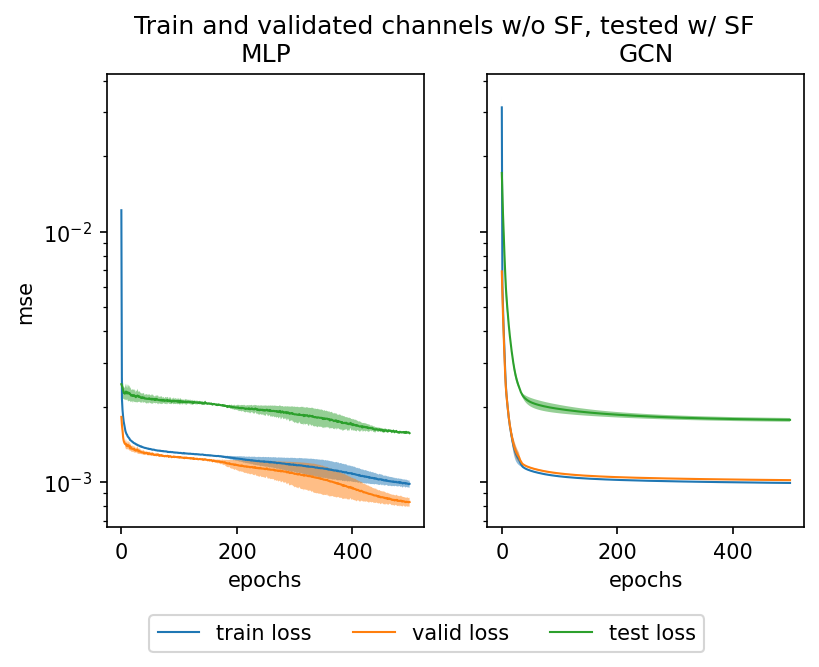

In [63]:

fig, ax = plt.subplots(1,2, dpi=150, sharey=True)

for ph, loss in zip(["train", "valid", "test"],[tr_loss, va_loss, te_loss]):

    m = np.mean(list(loss.values()),0)
    e = np.std(list(loss.values()),0)

    ax[0].plot(range(epoch+1), m, '-', linewidth=1, label='%s loss'%ph)
    ax[0].fill_between(range(epoch+1), m-e, m+e,
        alpha=.5, #edgecolor='#3F7F4C', facecolor='#7EFF99',
        linewidth=0, label=None)

for ph, loss in zip(["train", "valid", "test"],[tr_loss1, va_loss1, te_loss1]):

    m = np.mean(list(loss.values()),0)
    e = np.std(list(loss.values()),0)

    ax[1].plot(range(epoch+1), m, '-', linewidth=1, label='%s loss'%ph)
    ax[1].fill_between(range(epoch+1), m-e, m+e,
        alpha=.5, #edgecolor='#3F7F4C', facecolor='#7EFF99',
        linewidth=0, label=None)

ax[1].set_xlabel('epochs')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('mse')

ax[0].set_title('MLP')
ax[1].set_title('GCN')

plt.legend(bbox_to_anchor=(0.8,-0.1), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.yscale('log')
plt.suptitle('Train and validated channels w/o SF, tested w/ SF')

plt.show()

# MLP LEARNING

In [268]:
device = torch.device('cpu')
# model = MLP(num_ue).to(device)
# opt = torch.optim.Adam(model.parameters(), lr=0.01)
    
k_fold = 2
bs = 256


import numpy as np
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)
tr_loss, va_loss, te_loss = {},{},{}

for k, (train_index, valid_index) in enumerate(skf.split(X_tr, np.asarray([True]*y_tr.shape[0]))):
    # k fold cross validation
    
    X_train, y_train = X_tr[train_index], y_tr[train_index]
    X_valid, y_valid = X_tr[valid_index], y_tr[valid_index]
    X_test, y_test   = X_va[valid_index], y_va[valid_index]
    
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    tr_loss[k], va_loss[k], te_loss[k] = [],[],[]
    
    model = MLP(num_ue).to(device)
#     opt = torch.optim.Adam(model.parameters(), lr=0.01)
    opt = torch.optim.SGD(model.parameters(), lr=0.4)
    
    for epoch in trange(100, desc='%d-th fold:'%(k+1)):
        model.train()
        perm_i = np.random.permutation(y_train.shape[0])

        running_loss = 0
        for i in range(len(perm_i)//bs):

            i_s, i_e = i*bs, (i+1)*bs

            y_true = 10**torch.from_numpy(y_train[i_s:i_e]).float().to(device)
            x = torch.from_numpy(X_train[i_s:i_e]).float().to(device)

            y_pred = model(x)

            ## loss ee
            de_x = 10**(X_train[i_s:i_e])
            de_h = torch.Tensor((de_x[:,:-1]/de_x[:,-1][:, np.newaxis]).reshape((-1, 4,4)))
#             loss_ee = f(y_pred,de_h,mu,Pc)
            print(de_h.shape, y_pred.shape)
            
            s = de_h*y_pred.view((-1,1,num_ue)) # (4,4) * (4,) --> (4,4)

            direct = torch.diag(s)
            ifn = 1 + torch.sum(s, axis=-1) - direct
            rates = torch.log(1+direct/ifn)
            loss = rates / (mu * y_pred + Pc)
            
            print(loss)

            ##
            
#             loss = torch.mean(((y_pred-y_true)/y_true)**2, dim=0)

            opt.zero_grad()
            loss.backward(torch.ones(num_ue).to(device)) #vector loss
            opt.step()    

            running_loss += torch.mean(loss).item()

#             if not i%100:
#                 print('%d:%d/%d'%(epoch,i,y_tr.shape[0]), torch.mean(loss).item())
        tr_loss[k].append(running_loss/(i+1))

        model.eval()
        # validation
        y_pred = model( torch.from_numpy(X_valid).float().to(device) )
        y_true = 10**torch.from_numpy(y_valid).float().to(device)
        va_loss[k].append(torch.mean(((y_pred-y_true)/y_true)**2).item())   

        # test
        y_pred = model( torch.from_numpy(X_va).float().to(device) )
        y_true = 10**torch.from_numpy(y_va).float().to(device)
        te_loss[k].append(torch.mean(((y_pred-y_true)/y_true)**2).item())

        print('%d: train loss %.6f / val loss %.6f / test loss %.6f'%(
            epoch, tr_loss[k][-1], va_loss[k][-1], te_loss[k][-1]))
        
#     break

(25500, 17) (25500, 17) (25500, 4) (25500, 4)


torch.Size([256, 4, 4]) torch.Size([256, 4])



RuntimeError: matrix or a vector expected

In [269]:
s.shape

torch.Size([256, 4, 4])

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

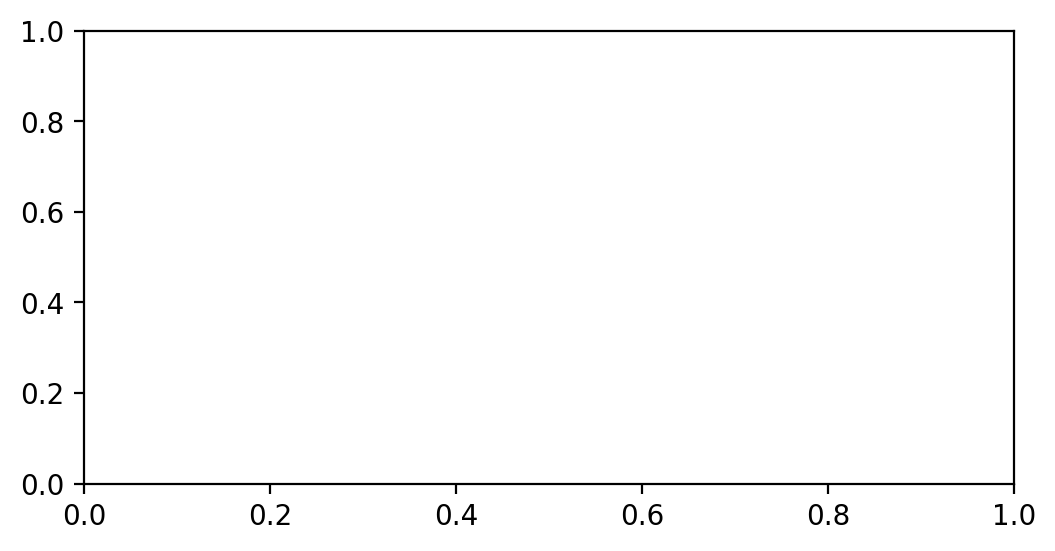

In [238]:

plt.figure(figsize=(6,3),  dpi=200)


for ph, loss in zip(["train", "valid", "test"],[tr_loss, va_loss, te_loss]):

    m = np.mean(list(loss.values()),0)
    e = np.std(list(loss.values()),0)

    plt.plot(range(epoch+1), m, '-', linewidth=1, label='%s loss'%ph)
    plt.fill_between(range(epoch+1), m-e, m+e,
        alpha=.5, #edgecolor='#3F7F4C', facecolor='#7EFF99',
        linewidth=0, label=None)


# plt.plot(range(epoch+1), np.mean(list(tr_loss.values()),0), '-', label='train loss')
# plt.plot(range(epoch+1), np.mean(list(va_loss.values()),0), '-', label='validation loss')
# plt.plot(range(epoch+1), np.mean(list(te_loss.values()),0), '-.', label='test loss')

plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()

plt.yscale('log')
plt.title('Train and validated channels w/o SF, tested w/ SF')

plt.show()

In [ ]:
ax

In [ ]:
def histogram(sample,bins=10, alpha=1, ax=None, label=None):
    if not bins:
        bins='auto'
    bin_height,bin_boundary = np.histogram(sample,bins=bins)
    width = bin_boundary[1]-bin_boundary[0]
    bin_height = bin_height/float(max(bin_height))
    if ax is not None:
        ax.bar(bin_boundary[:-1],bin_height,width = width, alpha=alpha, label=label)
    else:
        plt.bar(bin_boundary[:-1],bin_height,width = width, alpha=alpha, label=label)


fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=200)#, sharex=False, sharey=False)

histogram(X_va.flatten(),bins=80, alpha=.6, ax=ax[0], label='test')
histogram(X_tr.flatten(),bins=80, alpha=.6, ax=ax[0], label='train')

histogram(y_va.flatten(),bins=200, alpha=.6, ax=ax[1], label='test (SF)')
histogram(y_tr.flatten(),bins=200, alpha=.6, ax=ax[1], label='train (noSF)')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_title("channels")
ax[1].set_title("optim power alloc")

# plt.title("Data - hataUrban")
plt.legend()
plt.show()




In [ ]:
plt.hist(np.random.randn(300,3))


In [ ]:
plt.plot(p_perm, ee[14], '.', label='mlp', alpha=.7)
#     plt.plot(eeval[k],'.', label=k, alpha=.7)
plt.xticks(range(len(Plin))[::5], [np.round(pl,1) for pl in Plin[::5]])
plt.legend()
plt.show()

In [ ]:
p0, Pmax, model.pvar
f(model.pvar.detach().numpy(), h0)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot(np.array(ll).mean(-1))

ax[1].plot(ee)

plt.show()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot(np.array(ll).mean(-1))

ax[1].plot(ee)

plt.show()